# ENCODE bigWig analysis questions

Do your best to answer all parts of each question. You are encouraged to collaborate, but should turn in your own answers. 

Please limit each answer to a maximum of one markdown cell, one code cell and one plot. 

Put helper functions into a separate script (e.g. `hwutils.py`) so the notebook can be focused on plotting. Also see the [workshop on Clean Code](https://drive.google.com/file/d/1TraVwRkbkCbHq-s_-NS69ZEbRNwH8XNh/view) from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.


In [1]:
# useful libraries to import

import pandas as pd
import numpy as np

import  sklearn.decomposition

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b') 
# nice way to format ticks as human-readable: ax.xaxis.set_major_formatter(bp_formatter)

from hwutils import *

In [2]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('./data/ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')

<ipython-input-2-87c23df40917>:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')


- After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?


/root/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


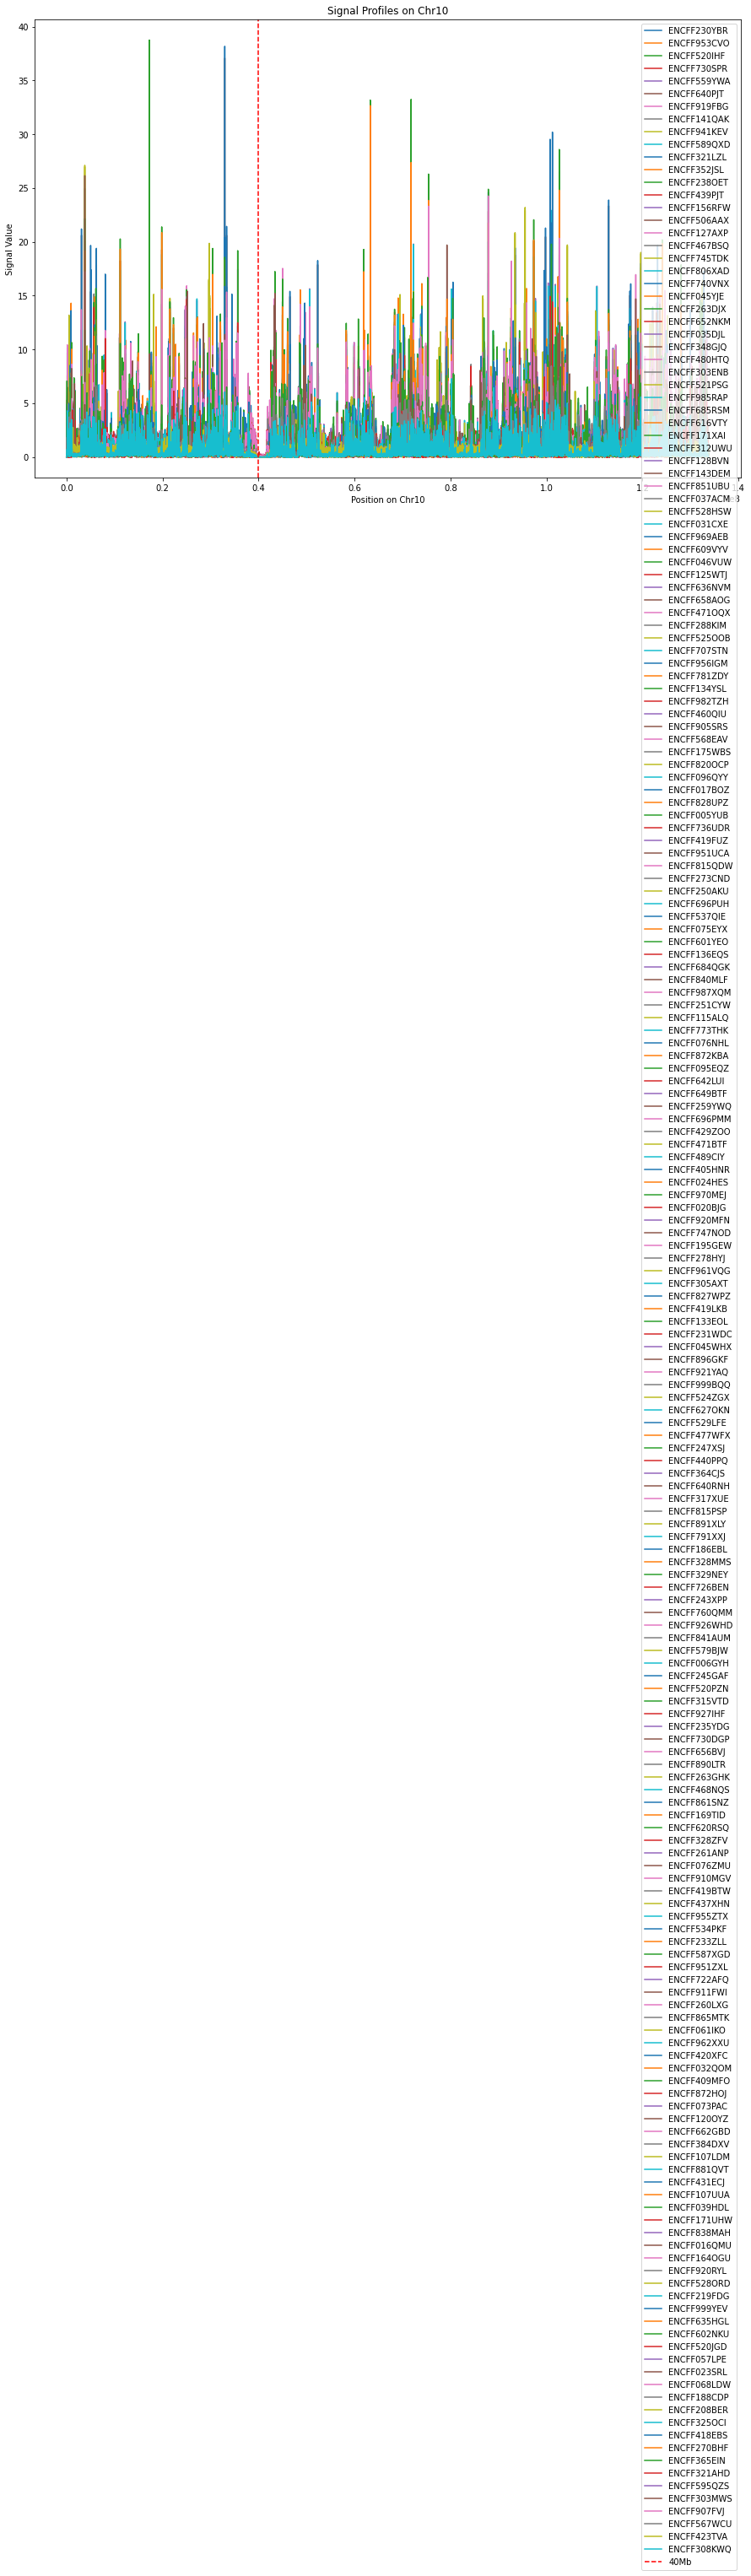

In [3]:
plt.figure(figsize=(15,10))

for column in df.columns[3:]:
    plt.plot(df['start'], df[column], label=column)

# line at 40Mb
plt.axvline(x=40e6, color='red', linestyle='--', label='40Mb')

plt.xlabel('Position on Chr10')
plt.ylabel('Signal Value')
plt.legend()
plt.title('Signal Profiles on Chr10')
plt.show()

There is a dip around 40 possibly because that is where the centromere is located.

- Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.


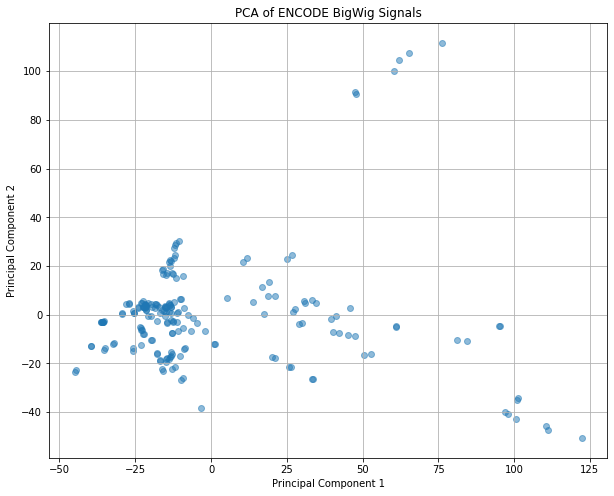

In [4]:
from sklearn.decomposition import PCA

data = df.iloc[:, 3:].T
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)

# Plotting the results without labels
plt.figure(figsize=(10, 8))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of ENCODE BigWig Signals')
plt.grid(True)
plt.show()

- Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that `sklearn.preprocessing.LabelEncoder()` can be useful for transforming text strings to categories, and `plt.text` can be used to overlay labels with points.

In [5]:
for col in bigwig_metadata.columns:
    print(col)

print(data)

Unnamed: 0
File accession
File format
File type
File format type
Output type
File assembly
Experiment accession
Assay
Donor(s)
Biosample term id
Biosample term name
Biosample type
Biosample organism
Biosample treatments
Biosample treatments amount
Biosample treatments duration
Biosample genetic modifications methods
Biosample genetic modifications categories
Biosample genetic modifications targets
Biosample genetic modifications gene targets
Biosample genetic modifications site coordinates
Biosample genetic modifications zygosity
Experiment target
Library made from
Library depleted in
Library extraction method
Library lysis method
Library crosslinking method
Library strand specific
Experiment date released
Project
RBNS protein concentration
Library fragmentation method
Library size range
Biological replicate(s)
Technical replicate(s)
Read length
Mapped read length
Run type
Paired end
Paired with
Index of
Derived from
Size
Lab
md5sum
dbxrefs
File download URL
Genome annotation
Platform


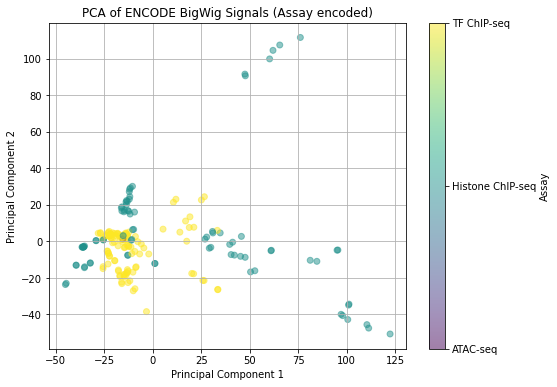

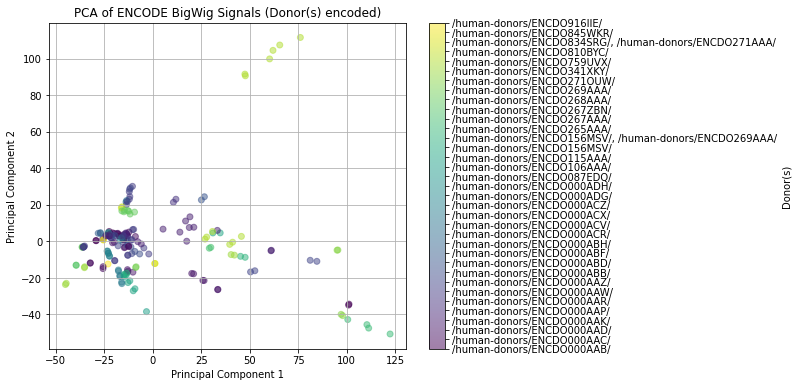

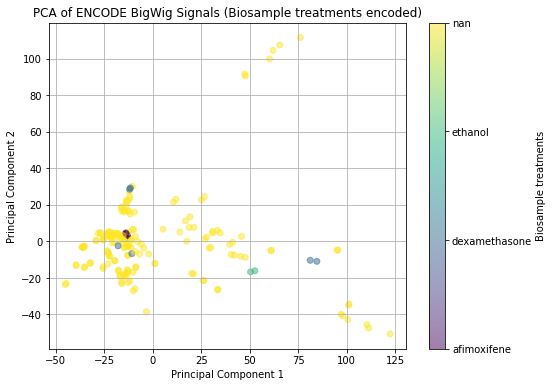

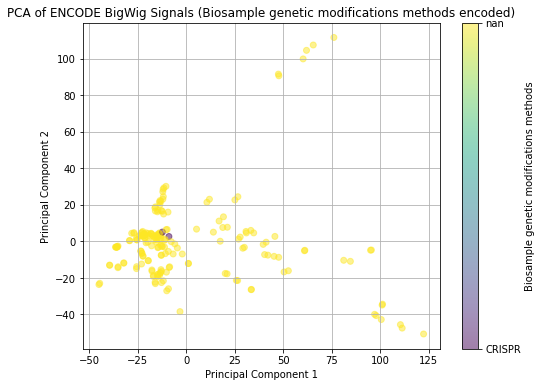

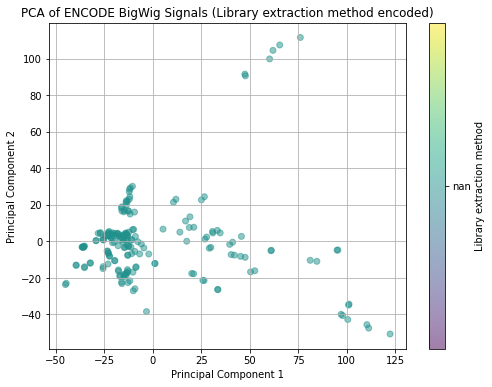

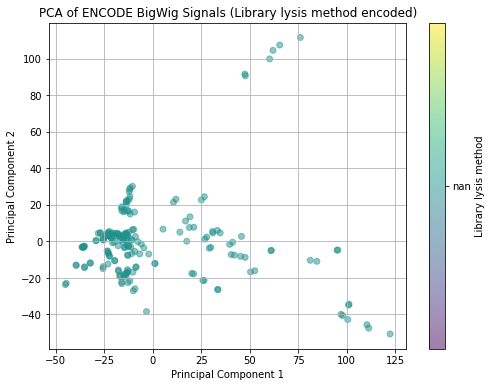

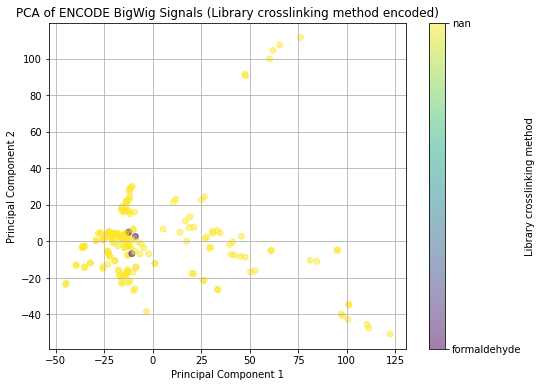

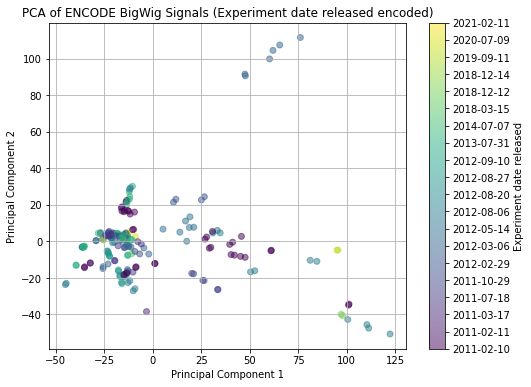

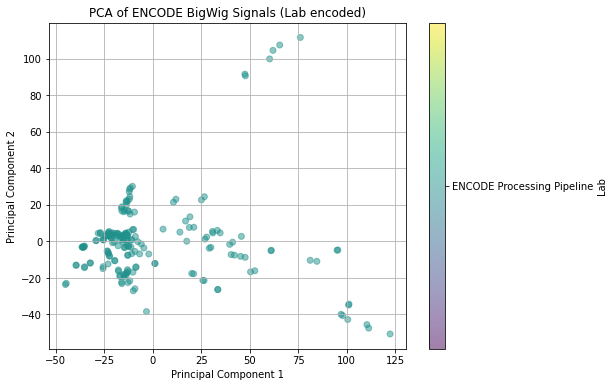

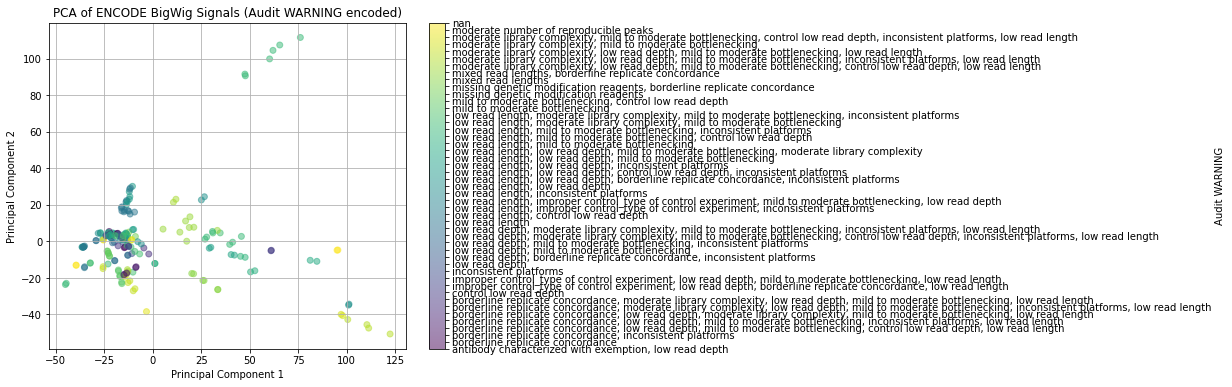

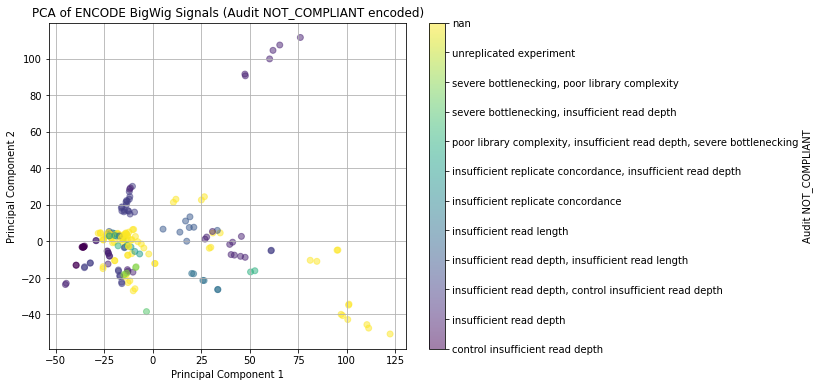

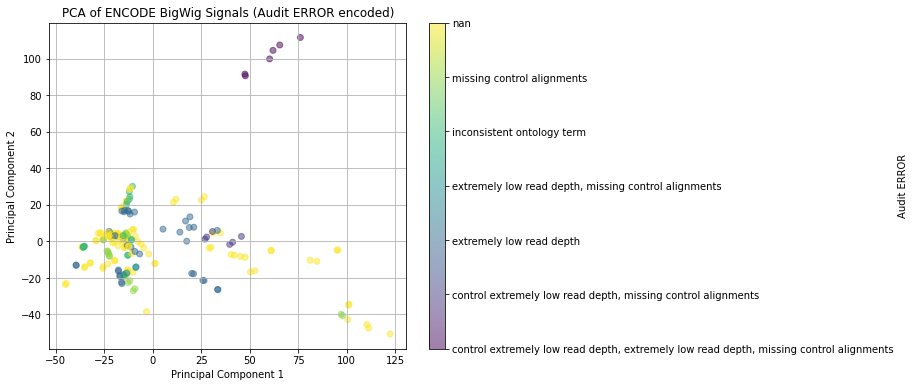

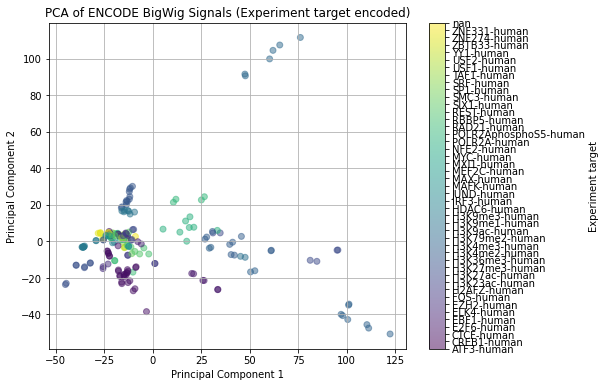

In [6]:
from sklearn.preprocessing import LabelEncoder

# Define a function to visualize PCA with labels or colors from metadata columns
def visualize_pca_with_metadata(column_name):
    # Map the metadata labels to the order of bigwig columns in df
    labels = bigwig_metadata.set_index('File accession').loc[data.index, column_name]
    
    if labels.dtype == 'object':
        le = LabelEncoder()
        labels = le.fit_transform(labels)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='viridis', alpha=0.5)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(f'PCA of ENCODE BigWig Signals ({column_name} encoded)')
    ax.grid(True)

    # Create a colorbar for labeled plots
    if bigwig_metadata[column_name].dtype == 'object':
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label(column_name)
        cbar.set_ticks(range(len(le.classes_)))
        cbar.set_ticklabels(le.classes_)

    plt.show()

# Columns that might be related to outliers
columns_to_check = [
    "Assay",
    "Donor(s)",
    "Biosample treatments",
    "Biosample genetic modifications methods",
    "Library extraction method",
    "Library lysis method",
    "Library crosslinking method",
    "Experiment date released",
    "Lab",
    "Audit WARNING",
    "Audit NOT_COMPLIANT",
    "Audit ERROR",
    "Experiment target"
]

for column in columns_to_check:
    visualize_pca_with_metadata(column)

seems like audit ERROR has the clearest contribution to outliers.

In [7]:
error_value = "control extremely low read depth, extremely low read depth, missing control alignments"
error_file_accessions = bigwig_metadata[
    bigwig_metadata['Audit ERROR'] == error_value
]['File accession'].values

# Filter the data dataframe to keep rows whose rownames (index) are NOT in the error_file_accessions
filtered_df = data[~data.index.isin(error_file_accessions)]
print(filtered_df)

             0         1         2         3         4         5      \
ENCFF230YBR    0.0  0.016585  0.000000  0.000000  0.049756  0.298538   
ENCFF953CVO    0.0  0.141369  0.000000  0.023561  0.094244  0.316690   
ENCFF520IHF    0.0  0.000000  0.000000  0.000000  0.052176  0.029577   
ENCFF730SPR    0.0  0.092070  0.041850  0.008370  0.442616  0.668383   
ENCFF559YWA    0.0  0.048068  0.010681  0.000000  0.181287  0.372467   
...            ...       ...       ...       ...       ...       ...   
ENCFF303MWS    0.0  0.045821  0.000000  0.000000  0.274925  0.366567   
ENCFF907FVJ    0.0  0.034791  0.000000  0.000000  0.138100  0.290266   
ENCFF567WCU    0.0  0.000000  0.000000  0.000000  0.025495  0.043950   
ENCFF423TVA    0.0  0.000000  0.000000  0.000000  0.073522  0.084935   
ENCFF308KWQ    0.0  0.000000  0.000000  0.000000  0.000000  0.055093   

                6         7         8         9      ...  13370  13371  13372  \
ENCFF230YBR  0.218297  0.433936  0.496646  0.716139  .

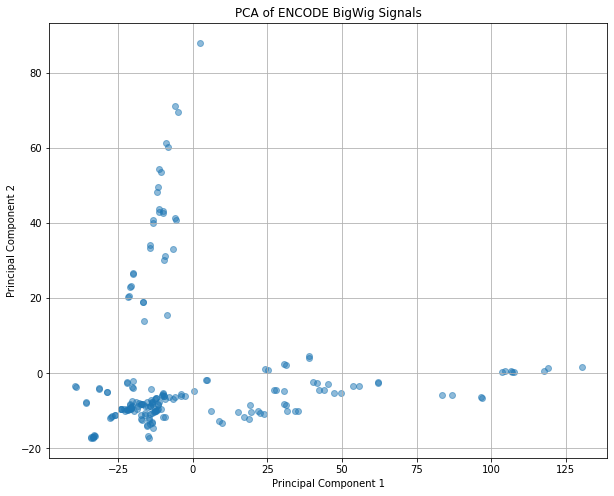

In [8]:
filtered_forpca = filtered_df
pca = PCA(n_components=2)
principal_components = pca.fit_transform(filtered_forpca)

# Plotting the results without labels
plt.figure(figsize=(10, 8))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of ENCODE BigWig Signals')
plt.grid(True)
plt.show()

- Which Assays or Experiment Targets show broad vs narrow patterns? Is this consistent across cell types? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.


    File accession             Assay Experiment target  Autocorrelation
0      ENCFF230YBR       TF ChIP-seq        ATF3-human         0.242189
1      ENCFF953CVO       TF ChIP-seq        CTCF-human         0.052587
2      ENCFF520IHF  Histone ChIP-seq     H3K4me2-human         0.042443
3      ENCFF730SPR  Histone ChIP-seq    H3K27me3-human         0.058018
4      ENCFF559YWA       TF ChIP-seq        EZH2-human         0.134048
..             ...               ...               ...              ...
189    ENCFF303MWS       TF ChIP-seq        REST-human         0.120096
190    ENCFF907FVJ       TF ChIP-seq       MEF2C-human         0.266028
191    ENCFF567WCU       TF ChIP-seq        CTCF-human         0.054258
192    ENCFF423TVA  Histone ChIP-seq     H3K27ac-human         0.195809
193    ENCFF308KWQ  Histone ChIP-seq     H3K4me2-human         0.041784

[194 rows x 4 columns]


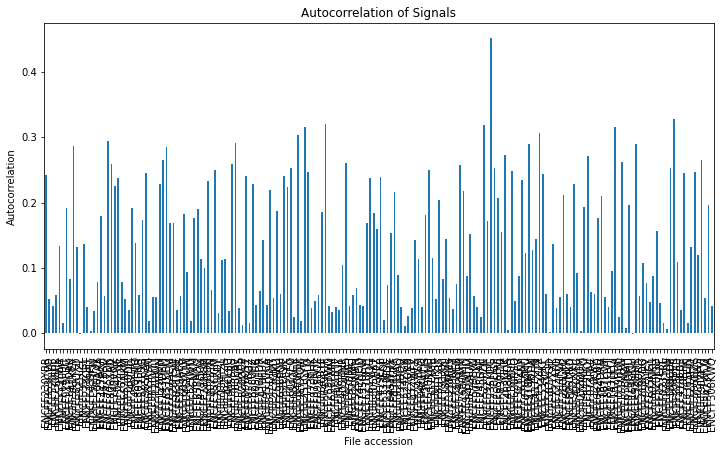

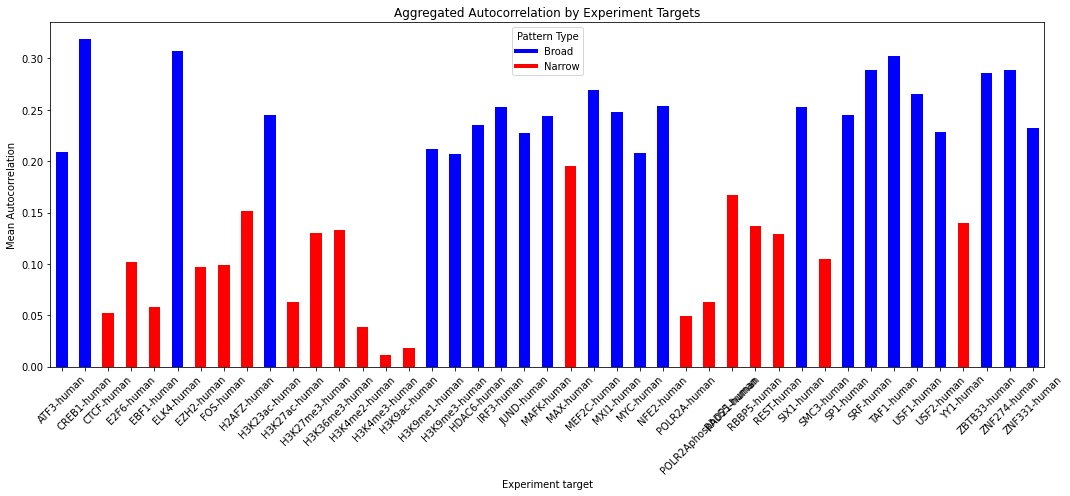

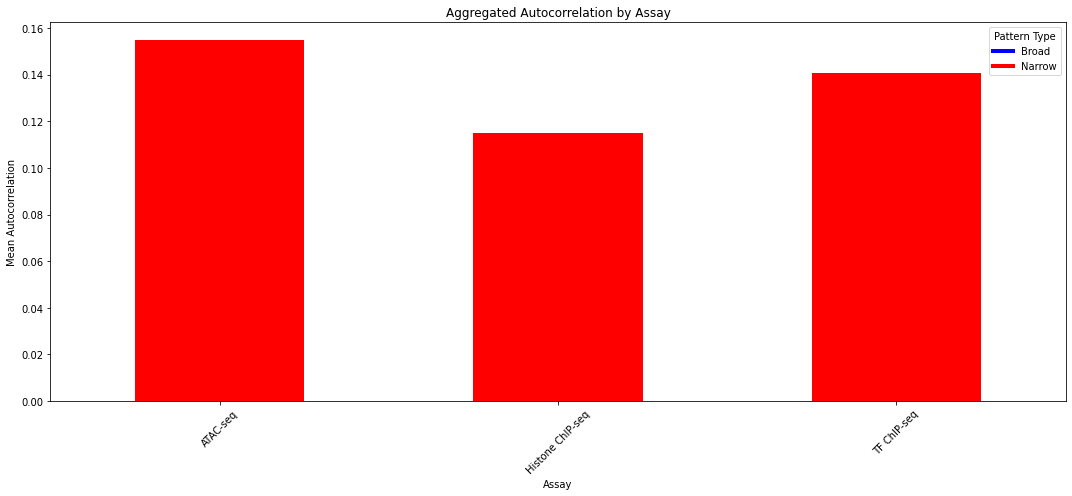

In [9]:
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))[0, 1]

autocorr_values = {}
for index, row in filtered_df.iterrows():
    file_accession = index  # assuming that the index contains the file accession
    autocorr_values[file_accession] = autocorr(row.values, t=100)

result = []
for key, value in autocorr_values.items():
    assay = bigwig_metadata.loc[bigwig_metadata['File accession'] == key, 'Assay'].values[0]
    experiment_target = bigwig_metadata.loc[bigwig_metadata['File accession'] == key, 'Experiment target'].values[0]
    result.append((key, assay, experiment_target, value))

result_df = pd.DataFrame(result, columns=['File accession', 'Assay', 'Experiment target', 'Autocorrelation'])

print(result_df)

plt.figure(figsize=(12, 6))
result_df.set_index('File accession')['Autocorrelation'].plot(kind='bar')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Signals')
plt.show()

agg_autocorr = result_df.groupby('Experiment target')['Autocorrelation'].mean().reset_index()

threshold = 0.2
agg_autocorr['Pattern'] = np.where(agg_autocorr['Autocorrelation'] > threshold, 'Broad', 'Narrow')

colors = {'Broad': 'blue', 'Narrow': 'red'}
bar_colors = agg_autocorr['Pattern'].map(colors)

plt.figure(figsize=(15, 7))
ax = agg_autocorr.set_index('Experiment target')['Autocorrelation'].plot(kind='bar', color=bar_colors)
plt.ylabel('Mean Autocorrelation')
plt.title('Aggregated Autocorrelation by Experiment Targets')
plt.xticks(rotation=45)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) for label, color in colors.items()]
ax.legend(handles=legend_elements, title='Pattern Type')

plt.tight_layout()
plt.show()

# Aggregate autocorrelation by assay
agg_autocorr = result_df.groupby('Assay')['Autocorrelation'].mean().reset_index()

threshold = 0.2
agg_autocorr['Pattern'] = np.where(agg_autocorr['Autocorrelation'] > threshold, 'Broad', 'Narrow')

colors = {'Broad': 'blue', 'Narrow': 'red'}
bar_colors = agg_autocorr['Pattern'].map(colors)

plt.figure(figsize=(15, 7))
ax = agg_autocorr.set_index('Assay')['Autocorrelation'].plot(kind='bar', color=bar_colors)
plt.ylabel('Mean Autocorrelation')
plt.title('Aggregated Autocorrelation by Assay')
plt.xticks(rotation=45)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) for label, color in colors.items()]
ax.legend(handles=legend_elements, title='Pattern Type')

plt.tight_layout()
plt.show()



looks like all of the assays are pretty narrow, with histone ChIP-seq being the narrowest. For experiment targets it looks like the H3K4s are the narrowest and ATF3-human is the broadest. I am not quite sure how to compare this with cell types. This does look similar to that patterns in PCA as the targets with similar autocorrelations appear to cluster together.

- Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.


In [10]:
from collections import Counter

list = bigwig_metadata['Experiment target'].unique().tolist()

tally = Counter(list)

for key, value in tally.items():
    print(f"{key}: {value}")

CTCF-human: 1
H3K27ac-human: 1
nan: 1
HDAC6-human: 1
H3K4me2-human: 1
H3K79me2-human: 1
EBF1-human: 1
SP1-human: 1
E2F6-human: 1
MAFK-human: 1
ZNF274-human: 1
H3K4me3-human: 1
H3K9me3-human: 1
IRF3-human: 1
SETDB1-human: 1
FOS-human: 1
RBBP5-human: 1
POLR2AphosphoS5-human: 1
USF1-human: 1
EP300-human: 1
RAD21-human: 1
TAF1-human: 1
MAX-human: 1
SRF-human: 1
MXI1-human: 1
H3K9ac-human: 1
JUND-human: 1
ZBTB33-human: 1
REST-human: 1
ATF3-human: 1
EZH2-human: 1
CREB1-human: 1
H3K36me3-human: 1
H2AFZ-human: 1
NFE2-human: 1
H3K27me3-human: 1
ELK4-human: 1
YY1-human: 1
MEF2C-human: 1
USF2-human: 1
MYC-human: 1
H3K9me1-human: 1
BCLAF1-human: 1
ZNF331-human: 1
SIX1-human: 1
GARS-human: 1
ZNF335-human: 1
SMC3-human: 1
RREB1-human: 1
CXXC1-human: 1
FUBP1-human: 1
NPM1-human: 1
E4F1-human: 1
ZNF124-human: 1
EIF4E-human: 1
NR3C1-human: 1
JUN-human: 1
SAFB-human: 1
ZKSCAN1-human: 1
H3K4me1-human: 1
MAZ-human: 1
ZNF143-human: 1
SIX5-human: 1
H4K12ac-human: 1
H2BK120ac-human: 1
ELF1-human: 1
NCOA1-hum

I am pretty confused where to find information on polycomb relations in the metadata. I am also confused because there are a ton of different experiment targets, how do I know which are histone marks and which are TFs. 

- How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that `sklearn.preprocessing.StandardScaler` could be useful for preprocessing. 


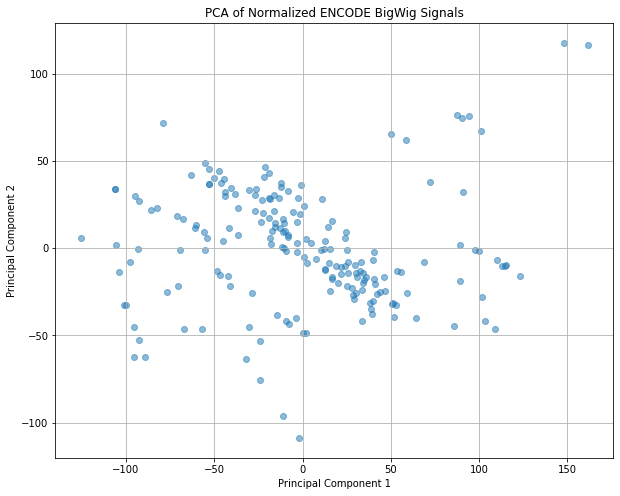

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

norm_data = scaler.fit_transform(filtered_df)

pca = PCA()
principal_components = pca.fit_transform(norm_data)

# Plotting the results without labels
plt.figure(figsize=(10, 8))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Normalized ENCODE BigWig Signals')
plt.grid(True)
plt.show()

- How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot). 


Number of PCs needed to explain 90% of variance: 43


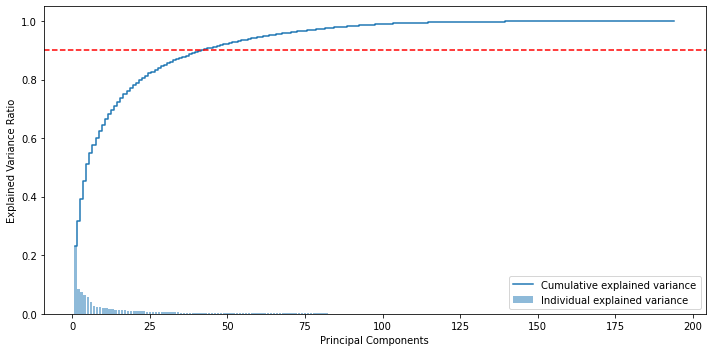

In [12]:
explained_variances = pca.explained_variance_ratio_.cumsum()

# Find number of PCs needed to explain 90% of variance
num_pcs = np.where(explained_variances >= 0.9)[0][0] + 1  # Adding 1 because index is 0-based

print(f'Number of PCs needed to explain 90% of variance: {num_pcs}')

# Plotting the Scree plot
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(pca.explained_variance_ratio_)+1), explained_variances, where='mid', label='Cumulative explained variance')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

- How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.


/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


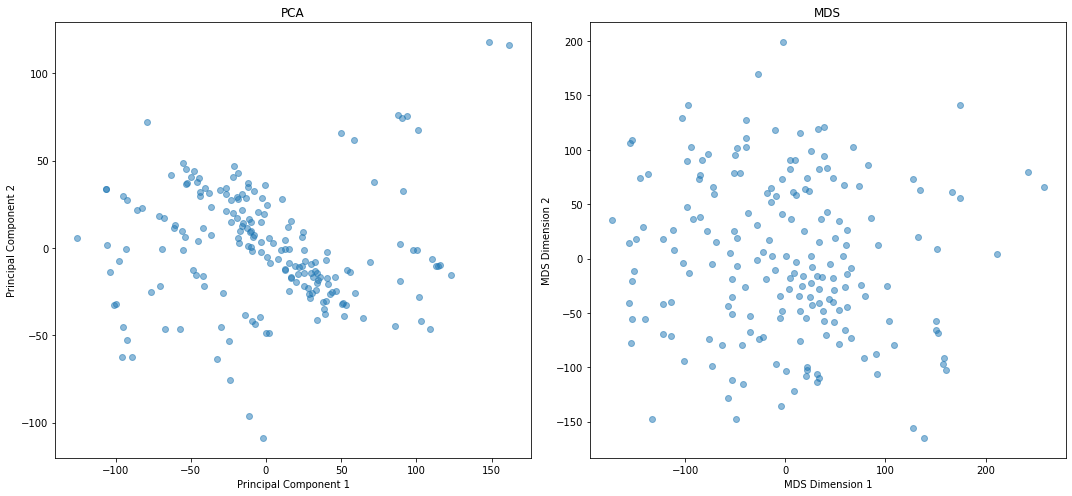

Correlation between PCA's first dimension and MDS's first dimension: 0.92
Correlation between PCA's second dimension and MDS's second dimension: 0.74


In [13]:
from sklearn.manifold import MDS

pca = PCA(n_components=2)
pca_result = pca.fit_transform(norm_data)

mds = MDS(n_components=2)
mds_result = mds.fit_transform(norm_data)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
ax[0].set_title('PCA')
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')

ax[1].scatter(mds_result[:, 0], mds_result[:, 1], alpha=0.5)
ax[1].set_title('MDS')
ax[1].set_xlabel('MDS Dimension 1')
ax[1].set_ylabel('MDS Dimension 2')

plt.tight_layout()
plt.show()

corr_dim1 = np.corrcoef(pca_result[:, 0], mds_result[:, 0])[0, 1]
corr_dim2 = np.corrcoef(pca_result[:, 1], mds_result[:, 1])[0, 1]

print(f"Correlation between PCA's first dimension and MDS's first dimension: {corr_dim1:.2f}")
print(f"Correlation between PCA's second dimension and MDS's second dimension: {corr_dim2:.2f}")

can use correlation values as well as just visual inspection. PCA tries to find the axes in the original high-dimensional space that maximize the variance of the data. The first principal component (PC1) is the direction that accounts for the largest variance in the data, second is second largest variance, etc. MDS tries to find a low-dimensional representation of the data that preserves the pairwise distances between data points as closely as possible. The first dimension of MDS is the representation that best approximates the pairwise distances in the original space.

- Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not?  (No plots needed for this question).


I think that NMF would not be that useful for this dataset because earlier i found that it would take 43 components to capture 90% of the variability, which suggests there isn't a small set of dominant features or patterns that capture most of the dataset's variability, so using NMF with less components probably wouldn't be ideal. I think NMF would still require a high number of components to be meaningful. 